# Complaint Routing Model

#### by Jeffrey Strickland, Ph.D.
#### 12 August 2019

## Introduction

### Goal: route complaints to the proper researched team based on product groupings. 

The business unit receives complaintsin the form of free text and wants to route the complaints to the wants to route the complaints to one of seven different depaertments (product_group name in the daata parenthesis:.
	1. Bank account or service (bank_servie)
	2. Credit card (credit_card)
	3. Credit reporting (credict_reporting)
	4. Debt collection (debt_collection)
	5. Lines of loans (loan)
	6. Money Transfers (money_transfers)
	7. Mortgage (mortgange)

We have obtained a data set wiith 286,362 records that contains complaint text (text), a message identifier (complaint_id) and a verified correct complaint department product_group).

### Methodology

- We created three differnet classification models for comparison:

    - Naive Bayes
    - Classification Tree
    - Random Forest

- For of natural language processing (NLP) we chose the bag-of-words method.

## Load Required Packages

In [1]:
#Standard packages
import pandas as pd
import numpy as np
import matplotlib


# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# Scikit Learn
from sklearn import preprocessing
from sklearn import tree
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, KFold

#Natural Language Toolkit
import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import wordnet as wn
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
lemmatiser = WordNetLemmatizer()

#String
import string

from matplotlib import pyplot as plt
# Allow plots in Notebook
%matplotlib inline

## Optional Packages

In [2]:
#Plotly
import plotly
import plotly.graph_objects as go
import plotly.express as px
import chart_studio.plotly as py
import re
from sodapy import Socrata
from pprint import pprint

# Spacy for lemmatization
import spacy

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)
import seaborn as sns
#nltk.download('punkt')
#nltk.download('wordnet')

### Loading (reading) the Dataset using Pandas
Our first step in the modeling process is to load the data. In this instance the data is contained in a CVS file that we will read into the Jupyter Notebook.

In [3]:
df = pd.read_csv("D:/Documents/Data/case_study_data_copy.csv")
corps = df[['complaint_id','product_group','text']]

### Data Exploration
The next several step we take are for exploring the complaint data, including listing the headings, viewing some records, and assessing the shape of the data frame.

In [4]:
list(corps)

['complaint_id', 'product_group', 'text']

In [5]:
corps.shape, train.shape, test.shape

NameError: name 'train' is not defined

### Data Exploration

In [6]:
corps.head(5) # for showing a snapshot of the dataset

,complaint_id,product_group,text
0,2815595,bank_service,On check was debited from checking account and...
1,2217937,bank_service,opened a Bank of the the West account The acc...
2,2657456,bank_service,in nj opened a business account without autho...
3,1414106,bank_service,A hold was placed on saving account because in...
4,1999158,bank_service,Dear CFPBneed to send a major concerncomplaint...


## Prepare a Frequency Distribution

The next step consist of plotting the frequency of complaints for each product group and plotting the word counts

In [7]:
# Provides calculation of the shape of the data for each product group
bank_service_len = df[df['product_group'] == 'bank_service'].shape[0]
mortgage_len = df[df['product_group'] == 'mortgage'].shape[0]
credit_reporting_len = df[df['product_group'] == 'credit_reporting'].shape[0]
loan_len = df[df['product_group'] == 'loan'].shape[0]
credit_card_len = df[df['product_group'] == 'credit_card'].shape[0]
debt_collection_len = df[df['product_group'] == 'debt_collection'].shape[0]
money_transfers_len = df[df['product_group'] == 'money_transfers'].shape[0]

In [8]:
# Returns that complaint frequencies for each product group
credit_reporting_len, mortgage_len, bank_service_len, loan_len, credit_card_len, money_transfers_len

(81234, 40281, 20071, 31036, 29553, 4734)

## Plotting the Data

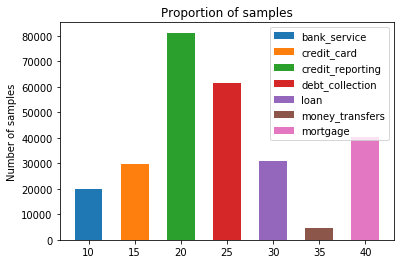

In [9]:
# Sets up the data for construct the frequency distribution (bar chart)
plt.bar(10,bank_service_len,3, label="bank_service")
plt.bar(15,credit_card_len,3, label="credit_card")
plt.bar(20,credit_reporting_len,3, label="credit_reporting")
plt.bar(25,debt_collection_len,3, label="debt_collection")
plt.bar(30,loan_len,3, label="loan")
plt.bar(35,money_transfers_len,3, label="money_transfers")
plt.bar(40,mortgage_len,3, label="mortgage")
plt.legend()
plt.ylabel('Number of samples')
plt.title('Proportion of samples')
plt.show()

## Store Product Group Data

The next step, and optional one, is to store the data for each product group into its own object for later use (potentially)

In [10]:
bks = df[df.product_group=="bank_service"]["text"].values
mtg = df[df.product_group=="mortgage"]["text"].values
crp = df[df.product_group=="credit_reporting"]["text"].values
ccd = df[df.product_group=="credit_card"]["text"].values
lon = df[df.product_group=="loan"]["text"].values
dct = df[df.product_group=="debt_collection"]["text"].values
mts = df[df.product_group=="money_transfers"]["text"].values

## Text Processing Steps:

1. Removal of Punctuation → All the punctuation marks are removed from all the text-snippets (instances or documents) from the dataset (corpus).
1. Lemmatisation → Inflected forms of a word are known as lemma. For example, (studying, studied) are inflected forms or lemma of the word study which is the root word. So, the lemma of a word are grouped under the single root word. This is done to make the vocabulary of words in the corpus contain distinct words only.
1. Removal of Stopwords → Stop-words are usually articles (a, an, the), prepositions (in, on, under, …) and other frequently occurring words that do not provide any key or necessary information. They are removed from all the text-snippets present in the dataset (corpus).

In [11]:
# Defining a module for Text Processing
def text_process(tex):
    
# 1. Removal of Punctuation Marks 
    nopunct=[char for char in tex if char not in string.punctuation]
    nopunct=''.join(nopunct)

# 2. Lemmatisation 
    a=''
    i=0
    for i in range(len(nopunct.split())):
        b=lemmatiser.lemmatize(nopunct.split()[i], pos="v")
        a=a+b+' '

# 3. Removal of Stopwords
    return [word for word in a.split() if word.lower() not 
            in stopwords.words('english')]

In [12]:
def text_prep(tex):
    """
    Takes in a string of text, then performs the following:
    1. Remove all punctuation
    2. Remove all stopwords
    3. Returns a list of the cleaned text
    """
    # Check characters to see if they are in punctuation
    nopunc = [char for char in tex if char not in string.punctuation]

    # Join the characters again to form the string.
    nopunc = ''.join(nopunc)
    
    # Now just remove any stopwords
    return [word for word in nopunc.split() if word.lower() not in stopwords.words('english')]

In [18]:
X = corps['text']

In [19]:
y = corps['product_group']

## Label Encoding of Classes:

- As this is a classification problem, here classes are the 7 product groups as mentioned. In our dataset, the labels are non-numeric (bank_services, credit_card, credit_reporting, debt_collection, loan, money_transfers, and mortgage). 
- These are label encoded to make them numeric, starting from 0 depicting each label in the alphabetic order i.e., (0 → bank_services, 1 → credit_card, 2 → credit_reporting, 3 → debt_collection, 4 → loan, 5 → money_transfers, and 5 → mortgage).

In [20]:
# Importing necessary libraries
from sklearn.preprocessing import LabelEncoder
#y = corps['product_group']
#X = corps['text']
labelencoder = LabelEncoder()
yL = labelencoder.fit_transform(y)

In [21]:
print(labelencoder.fit_transform(y))

[0 0 0 ... 6 6 6]


## Word Cloud Visualization:

We developed the word clouds as follows:

- Product groups have their own unique words and phrases, as well as some common ones
- visualization of the mostly-used words to the least-used words for the product groups can be demonstrated
- Seven text snippets, each belonging to the seven product groups, respectively, can render a Word Cloud

In [22]:
# Importing necessary libraries
from PIL import Image
from wordcloud import WordCloud
import matplotlib.pyplot as plt

X = df['text']

wordcloud0 = WordCloud().generate(X[0]) # for bank_service
wordcloud1 = WordCloud().generate(X[1]) # for credit_card
wordcloud2 = WordCloud().generate(X[2]) # for credit_reporting 
wordcloud3 = WordCloud().generate(X[3]) # for debt_collection 
wordcloud4 = WordCloud().generate(X[4]) # for loan
wordcloud5 = WordCloud().generate(X[5]) # for money_transfers
wordcloud6 = WordCloud().generate(X[6]) # for mortgage


bank_service


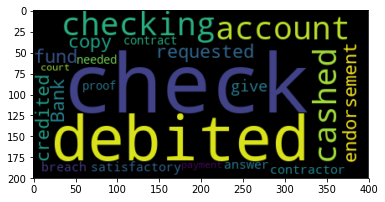

In [23]:
#print(X[0])
print(df['product_group'][0])
plt.imshow(wordcloud0, interpolation='bilinear')
plt.show()



credit_card


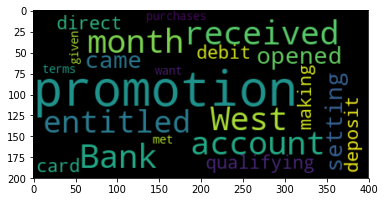

In [24]:
#print(X[22100])
print(df['product_group'][22100])
plt.imshow(wordcloud1, interpolation='bilinear')
plt.show()



credit_card


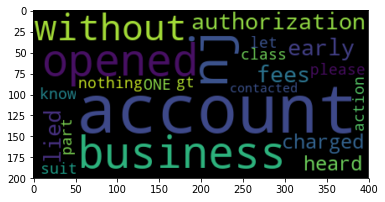

In [25]:
#print(X[42000])
print(df['product_group'][42000])
plt.imshow(wordcloud2, interpolation='bilinear')
plt.show()



debt_collection


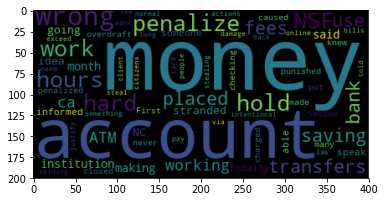

In [26]:
#print(X[152100])
print(df['product_group'][152100])
plt.imshow(wordcloud3, interpolation='bilinear')
plt.show()



loan


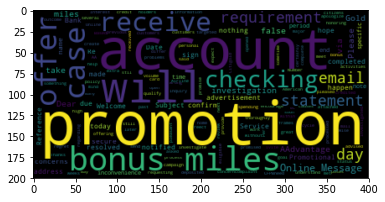

In [27]:
#print(X[199100])
print(df['product_group'][199100])
plt.imshow(wordcloud4, interpolation='bilinear')
plt.show()



money_transfers


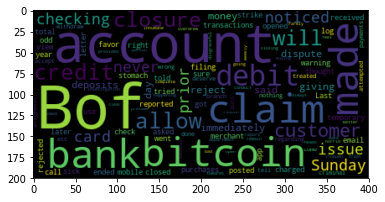

In [28]:
#print(X[227100])
print(df['product_group'][227100])
plt.imshow(wordcloud5, interpolation='bilinear')
plt.show()



mortgage


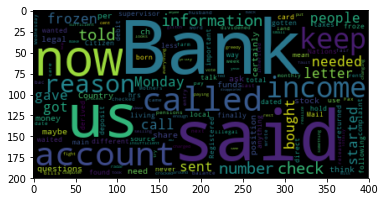

In [29]:
#print(X[237100])
print(df['product_group'][237100])
plt.imshow(wordcloud6, interpolation='bilinear')
plt.show()

## Create Train and Test Sets

In [118]:
# Importing necessary libraries
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

#80-20 splitting the dataset (80%->Training and 20%->Validation)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1234)

## Feature Engineering using Bag-of-Words:

- Machine Learning Algorithms work only on numeric data. 
- But here, data is present in the form of text only. 
- For that, by some means, textual data needs to be transformed into numeric form. 
- One such approach of doing this, is Feature Engineering. 
- In this approach, numeric features are extracted or engineered from textual data. 
- There are many Feature Engineering Techniques in existence. 
- In this problem, Bag-of-Words Technique of Feature Engineering has been used.

### Bag-of-Words (BOW):

- With Bag-of-Words a vocabulary of words present in the corpus is maintained. 
- These words serve as features for each instance or document (each complaint). 
- Against each word as feature, its frequency in the current document (complaint) is considered. 
- In this way word features are engineered or extracted from the textual data or corpus.

### BOW Preparation

In [31]:
import nltk
# create the transform
vectorizer = CountVectorizer()
# tokenize and build vocab
#word_vectorizer = CountVectorizer(analyzer='word', ngram_range=(1, 2), min_df=1)
#text_train = word_vectorizer.fit(X_train)
#text_test = word_vectorizer.fit(X_test)

In [76]:
# Defining the bag-of-words transformer on the text-processed corpus 
# i.e., text_process() declared in II is executed...
# nltk.download('stopwords')
import nltk
# create the transform
vectorizer = CountVectorizer()
bow_transformer_train=CountVectorizer().fit(X_train)
bow_transformer_test=CountVectorizer().fit(X_test)

In [53]:
from sklearn.feature_extraction.text import HashingVectorizer
# list of text documents
#text = X
# create the transform
#vectorizer = HashingVectorizer(n_features=20)
# encode document
#vector = vectorizer.transform(text)
# summarize encoded vector
#print(vector.shape)
#print(vector.toarray())

In [102]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1234)

In [33]:
bow_transformer=CountVectorizer(analyzer=text_prep).fit(X_train)

In [34]:
# transforming into Bag-of-Words and hence textual data to numeric..
text_bow_train=bow_transformer.transform(X_train)#ONLY TRAINING DATA

In [35]:
# transforming into Bag-of-Words and hence textual data to numeric..
text_bow_test=bow_transformer.transform(X_test)#TEST DATA

In [57]:
print(text_bow_train)

  (0, 51840)	1
  (0, 52120)	1
  (0, 59641)	1
  (0, 65939)	1
  (0, 68315)	2
  (0, 70586)	1
  (0, 73127)	1
  (0, 78900)	1
  (0, 83366)	1
  (0, 85115)	1
  (0, 90335)	1
  (0, 93394)	1
  (0, 93510)	1
  (0, 94403)	1
  (0, 96701)	1
  (0, 102012)	1
  (0, 103789)	2
  (0, 109404)	1
  (0, 119580)	1
  (0, 124540)	2
  (0, 131716)	1
  (1, 3108)	1
  (1, 7197)	5
  (1, 11054)	1
  (1, 21045)	3
  :	:
  (187865, 86804)	2
  (187865, 87836)	1
  (187865, 92627)	2
  (187865, 92691)	1
  (187865, 97906)	1
  (187865, 97932)	1
  (187865, 99784)	1
  (187865, 100147)	1
  (187865, 102847)	3
  (187865, 102857)	1
  (187865, 109677)	1
  (187865, 110808)	1
  (187865, 111362)	1
  (187865, 112207)	2
  (187865, 112644)	1
  (187865, 113195)	1
  (187865, 115842)	1
  (187865, 116223)	2
  (187865, 117159)	1
  (187865, 117548)	2
  (187865, 118245)	1
  (187865, 120968)	1
  (187865, 128601)	2
  (187865, 129305)	1
  (187865, 130560)	1


In [58]:
print(text_bow_test)

  (0, 136)	1
  (0, 6382)	1
  (0, 7011)	1
  (0, 14084)	2
  (0, 14355)	2
  (0, 18348)	2
  (0, 21454)	1
  (0, 21490)	1
  (0, 22739)	1
  (0, 37725)	3
  (0, 40755)	1
  (0, 42903)	1
  (0, 51280)	1
  (0, 51584)	1
  (0, 52311)	7
  (0, 52475)	11
  (0, 54600)	2
  (0, 55129)	1
  (0, 55657)	1
  (0, 56119)	3
  (0, 56131)	1
  (0, 57062)	2
  (0, 57271)	1
  (0, 57530)	1
  (0, 57615)	1
  :	:
  (80513, 107877)	1
  (80513, 109645)	1
  (80513, 110131)	1
  (80513, 111639)	1
  (80513, 112629)	2
  (80513, 114956)	1
  (80513, 115747)	1
  (80513, 116151)	1
  (80513, 116223)	1
  (80513, 117380)	1
  (80513, 119412)	1
  (80513, 119417)	2
  (80513, 119562)	1
  (80513, 119580)	1
  (80513, 123573)	1
  (80513, 125800)	2
  (80513, 126035)	1
  (80513, 128126)	1
  (80513, 128297)	1
  (80513, 128362)	1
  (80513, 129305)	1
  (80513, 130809)	1
  (80513, 131377)	1
  (80513, 131846)	1
  (80513, 132158)	1


## Training the Multinomial Naive Bayes Model:

Multinomial Naive Bayes Algorithm (Classifier) has been used as the Classification Machine Learning Algorithm [1].

In [37]:
from sklearn.naive_bayes import MultinomialNB
#clf = MultinomialNB().fit(X_train_tfidf, y_train)

In [52]:
X_train.size, text_bow_train.size, y_train.size

(187866, 11571246, 187866)

In [45]:
# Importing necessary libraries
from sklearn.naive_bayes import MultinomialNB

# instantiating the model with Multinomial Naive Bayes..
model = MultinomialNB()

# training the model...
model = model.fit(text_bow_train, y_train)

In [46]:
model.score(text_bow_train, y_train)

0.8269032182513067

### Model Performance Analysis:

#### Training Accuracy

In [51]:
X_train.size, text_bow_train.size, y_train.size

(187866, 11571246, 187866)

In [50]:
X_test.size, text_bow_test.size, y_test.size

(80514, 4941354, 80514)

In [48]:
bayes_score = model.score(text_bow_test, y_test)
bayes_score

0.8131132473855479

#### Validation Accuracy

In [59]:
bayes_val_score = model.score(text_bow_test, y_test)
bayes_val_score

0.8131132473855479

The cross-validation score is very close to the model score, 80.99 versus 82.44. The naive Bayes model is a good fit of the data and will produce good predictions.


### Precision, Recall and F1–Score

In [60]:
# Importing necessary libraries
from sklearn.metrics import classification_report
 
# getting the predictions of the Validation Set...
bayes_preds = model.predict(text_bow_test)

# getting the Precision, Recall, F1-Score
print(classification_report(y_test,bayes_preds))

                  precision    recall  f1-score   support

    bank_service       0.76      0.82      0.79      5999
     credit_card       0.73      0.77      0.75      8847
credit_reporting       0.83      0.83      0.83     24445
 debt_collection       0.83      0.77      0.80     18481
            loan       0.74      0.78      0.76      9314
 money_transfers       0.90      0.58      0.70      1422
        mortgage       0.90      0.92      0.91     12006

     avg / total       0.81      0.81      0.81     80514



### Naive Bayes Predictions

In [61]:
bayes_preds[0:10]

array(['credit_reporting', 'credit_card', 'credit_reporting',
       'credit_card', 'mortgage', 'credit_reporting', 'bank_service',
       'debt_collection', 'credit_reporting', 'credit_reporting'],
      dtype='<U16')

In [62]:
model.predict_proba(text_bow_test)

array([[1.96163636e-64, 3.68264399e-54, 1.00000000e+00, ...,
        1.82289745e-69, 4.34615419e-98, 1.81945327e-69],
       [9.86485846e-07, 9.98411675e-01, 1.58729751e-03, ...,
        1.67364088e-11, 9.71595187e-13, 2.30865676e-13],
       [1.39701122e-26, 9.66237698e-24, 1.00000000e+00, ...,
        2.49981276e-22, 1.70599217e-32, 7.00265283e-31],
       ...,
       [2.09212552e-04, 9.99790787e-01, 2.68461844e-18, ...,
        6.78341027e-14, 9.68134781e-16, 2.61362855e-15],
       [1.41957712e-01, 5.85232805e-06, 1.46095100e-08, ...,
        1.85685276e-12, 1.38358592e-19, 4.17527362e-16],
       [5.33449772e-58, 2.38661955e-61, 2.27497748e-24, ...,
        1.22994823e-47, 1.25568848e-84, 8.46819882e-14]])

### Confusion Matrix

In [63]:
from sklearn import svm, datasets
from sklearn.cross_validation import train_test_split
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[ 4925   517   199    90    71    62   135]
 [  561  6800   858   351   208    18    51]
 [  152  1015 20331  1549   968     5   425]
 [  113   530  2228 14273   995     6   336]
 [  173   267   679   711  7268     2   214]
 [  422   115    11    20    21   818    15]
 [  116   110   321   162   244     1 11052]]


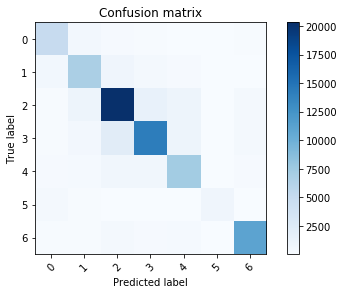

In [64]:
# Compute confusion matrix
cm = confusion_matrix(y_test,bayes_preds)
np.set_printoptions(precision=2)
print('Confusion matrix, without normalization')
print(cm)
plt.figure()
plot_confusion_matrix(cm, classes=[0,1,2,3,4,5,6])

Normalized confusion matrix
[[8.21e-01 8.62e-02 3.32e-02 1.50e-02 1.18e-02 1.03e-02 2.25e-02]
 [6.34e-02 7.69e-01 9.70e-02 3.97e-02 2.35e-02 2.03e-03 5.76e-03]
 [6.22e-03 4.15e-02 8.32e-01 6.34e-02 3.96e-02 2.05e-04 1.74e-02]
 [6.11e-03 2.87e-02 1.21e-01 7.72e-01 5.38e-02 3.25e-04 1.82e-02]
 [1.86e-02 2.87e-02 7.29e-02 7.63e-02 7.80e-01 2.15e-04 2.30e-02]
 [2.97e-01 8.09e-02 7.74e-03 1.41e-02 1.48e-02 5.75e-01 1.05e-02]
 [9.66e-03 9.16e-03 2.67e-02 1.35e-02 2.03e-02 8.33e-05 9.21e-01]]


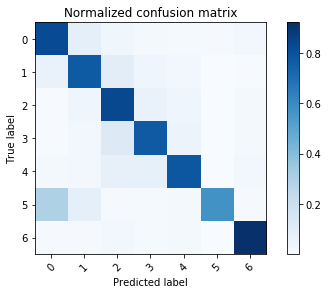

In [65]:
# Normalize the confusion matrix by row (i.e by the number of samples in each class)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print('Normalized confusion matrix')
print(cm_normalized)
plt.figure()
plot_confusion_matrix(cm_normalized, classes=[0,1,2,3,4,5,6],title='Normalized confusion matrix')
plt.show()

# Training the Classification Tree Model

In [70]:
from sklearn import tree
clf_class = tree.DecisionTreeClassifier()
clf_class = clf_class.fit(text_bow_train, y_train)

In [71]:
clf_class

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

### Classification Tree Scores

In [72]:
from sklearn import tree

In [73]:
tree_score = clf_class.score(text_bow_train, y_train)
tree_score

0.9991802667859006

In [74]:
tree_val_score = clf.score(text_bow_test, y_test)
tree_val_score

0.8131132473855479

The cross-validation score is much lower than the model score, 75.83 versus 99.91. The classificaton tree model is over-fitting the data and will produce numerous false positives.


### Classification Tree Predictions

In [75]:
tree_preds = clf.predict(text_bow_test)
tree_preds[0:10]

array(['credit_reporting', 'credit_card', 'credit_reporting',
       'credit_card', 'mortgage', 'credit_reporting', 'bank_service',
       'debt_collection', 'credit_reporting', 'credit_reporting'],
      dtype='<U16')

In [76]:
clf.predict_proba(text_bow_test)

array([[1.96e-64, 3.68e-54, 1.00e+00, ..., 1.82e-69, 4.35e-98, 1.82e-69],
       [9.86e-07, 9.98e-01, 1.59e-03, ..., 1.67e-11, 9.72e-13, 2.31e-13],
       [1.40e-26, 9.66e-24, 1.00e+00, ..., 2.50e-22, 1.71e-32, 7.00e-31],
       ...,
       [2.09e-04, 1.00e+00, 2.68e-18, ..., 6.78e-14, 9.68e-16, 2.61e-15],
       [1.42e-01, 5.85e-06, 1.46e-08, ..., 1.86e-12, 1.38e-19, 4.18e-16],
       [5.33e-58, 2.39e-61, 2.27e-24, ..., 1.23e-47, 1.26e-84, 8.47e-14]])

### Tree Summary

According to the Performance Analysis, we can conclude that this model may be overfitting the data, given th significant difference wetween train and test scores. 
- Train: 99.91% 
- Test: 75.94%

# Training the Random Forest Model

In [77]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.cross_validation import cross_val_score

In [78]:
rf = RandomForestClassifier(n_estimators=100) # initialize
rf.fit(text_bow_train, y_train) # fit the data to the algorithm

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

### Random Forest Model Scores

In [79]:
forest_score = rf.score(text_bow_train, y_train)
forest_score

0.9991802667859006

In [80]:
forest_val_score = rf.score(text_bow_test, y_test)
forest_val_score

0.8239188215714037

In [81]:
rf.get_params(rf.fit)

{'bootstrap': True,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': 1,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

### Random Forest Predictions

In [82]:
forest_preds = rf.predict(text_bow_test)
forest_preds[0:10]

array(['credit_reporting', 'credit_card', 'credit_reporting',
       'credit_card', 'mortgage', 'credit_reporting', 'credit_reporting',
       'debt_collection', 'credit_reporting', 'credit_reporting'],
      dtype=object)

In [83]:
rf.predict_proba(text_bow_test)[0:10]

array([[0.02, 0.04, 0.61, 0.28, 0.02, 0.  , 0.03],
       [0.09, 0.33, 0.33, 0.15, 0.05, 0.  , 0.05],
       [0.  , 0.02, 0.89, 0.04, 0.04, 0.  , 0.01],
       [0.06, 0.43, 0.16, 0.22, 0.06, 0.02, 0.05],
       [0.04, 0.05, 0.09, 0.12, 0.15, 0.02, 0.53],
       [0.01, 0.  , 0.94, 0.02, 0.01, 0.01, 0.01],
       [0.12, 0.12, 0.59, 0.1 , 0.03, 0.02, 0.02],
       [0.02, 0.08, 0.32, 0.51, 0.05, 0.01, 0.01],
       [0.06, 0.08, 0.56, 0.16, 0.06, 0.04, 0.04],
       [0.08, 0.08, 0.62, 0.09, 0.01, 0.01, 0.11]])

### Random Forest Summary

The random forest model is probably over-fitting the data and will produce numerous false positives. The cross-validation score is much lower than the model score. 
- Train: 99.91. 
- Test: 82.45  

# Model Comparisons

In [84]:
bayes_preds[0:20], tree_preds[0:20], forest_preds[0:20]

(array(['credit_reporting', 'credit_card', 'credit_reporting',
        'credit_card', 'mortgage', 'credit_reporting', 'bank_service',
        'debt_collection', 'credit_reporting', 'credit_reporting',
        'bank_service', 'debt_collection', 'credit_reporting', 'loan',
        'credit_card', 'loan', 'credit_reporting', 'mortgage', 'mortgage',
        'loan'], dtype='<U16'),
 array(['credit_reporting', 'credit_card', 'credit_reporting',
        'credit_card', 'mortgage', 'credit_reporting', 'bank_service',
        'debt_collection', 'credit_reporting', 'credit_reporting',
        'bank_service', 'debt_collection', 'credit_reporting', 'loan',
        'credit_card', 'loan', 'credit_reporting', 'mortgage', 'mortgage',
        'loan'], dtype='<U16'),
 array(['credit_reporting', 'credit_card', 'credit_reporting',
        'credit_card', 'mortgage', 'credit_reporting', 'credit_reporting',
        'debt_collection', 'credit_reporting', 'credit_reporting',
        'bank_service', 'debt_collect

In [85]:
bayes_score, bayes_val_score, tree_score, tree_val_score, forest_score, forest_val_score

(0.8131132473855479,
 0.8131132473855479,
 0.9991802667859006,
 0.8131132473855479,
 0.9991802667859006,
 0.8239188215714037)

# Conclusion

- The Classification and Random Forest models will have a tendency to over-predict. 
- While the Naive Bayes was trained having a lower performnce score (82,44),it will have more accurate predictions. 
- If we had an out-of-time sample, we could perform better validations on the three models. 
- In the mean time, we recommend the Naive Bayes Classification MOdel. 

## Backup Material

#### Legend
- 0 = bank service
- 1 = credit card
- 2 = credit reporting
- 3 = debt collection
- 4 = loan
- 5 = money transfers
- 6 = mortgage

In [86]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
comp=bow_transformer.transform(["This company refuses to provide me verification and validation of debt per my right under the FDCPA. I do not believe this debt is mine."])
print(model.predict(comp))

['debt_collection']


In [87]:
comp2=bow_transformer.transform(["someone stole my credit card and used it at walmart. I received a credit card alert on my mastercard."])
print(model.predict(comp2))

['credit_card']


In [88]:
comp3=bow_transformer.transform(["I am trying tos get a second morgage. the rate on my original mortgage is high."])
print(model.predict(comp3))

['mortgage']


In [89]:
comp3=bow_transformer.transform(["I wanted to get a loan to purchase a new car, but they said my credit score was too low due to other outstanding loans. I don't see what the big deal is with having other loans."])
print(model.predict(comp3))

['loan']


## Multi-layer Perceptron Classifier

In [90]:
from sklearn.neural_network import MLPClassifier
mlpc = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(10, 4), random_state=1)
mlpc.fit(text_bow_train, y_train)

MLPClassifier(activation='relu', alpha=1e-05, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(10, 4), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=1, shuffle=True,
       solver='lbfgs', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False)

### MLPClassifier Scores
#### *Training Accuracy*

In [91]:
MLPC_score = mlpc.score(text_bow_train, y_train)
MLPC_score

0.9191711113240288

#### Validation Accuracy

In [92]:
MLPC_val_score = mlpc.score(text_bow_test, y_test)
MLPC_val_score

0.8239064013711901

The cross-validation score is very close to the model score, 88.21 versus 81.87. The naive Bayes model is a good fit of the data and will produce good predictions.

## Multi-class Support Vector Machine

In [93]:
from sklearn import svm
svm_class = svm.LinearSVC()
svm_class.fit(text_bow_train, y_train)
svm_score = svm_class.score(text_bow_train, y_train)
svm_score

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

### SVM Scores
#### *Training Accuracy*

In [94]:
SVM_score = svm_class.score(text_bow_train, y_train)
SVM_score

0.9570651421758062

#### *Validation Accuracy*

In [95]:
SVM_val_score = svm_class.score(text_bow_test, y_test)
SVM_val_score

0.8096852721265867

The cross-validation score is very close to the model score, 94.32 versus 81.25. The naive Bayes model is a good fit of the data and will produce good predictions.


# PART II. Multi-Class Text Classification

## 7. Data Exploration and Preparation

As we stated in paragraph 3, we perform Multi-Class Text Classification
using a number of models, including a support vector machine (SVM),
multinomial Bayes classification mode, random forest classification
model, and a multinomial logistic regression model. Our goal here is to
get a better outcome than afforded by our initial analysis (Part I).

### 7.1. Data Exploration

Before diving into training our machine learning models, we take another
look at the distribution of complaints in each class using a histogram.


In [96]:
dfm = df[['product_group','complaint_id','text']]
dfm.head(10)

,product_group,complaint_id,text
0,bank_service,2815595,On check was debited from checking account and...
1,bank_service,2217937,opened a Bank of the the West account The acc...
2,bank_service,2657456,in nj opened a business account without autho...
3,bank_service,1414106,A hold was placed on saving account because in...
4,bank_service,1999158,Dear CFPBneed to send a major concerncomplaint...
5,bank_service,2862448,Bank closed checking account with no prior war...
6,bank_service,1695009,complaint is against Bank have had a account ...
7,bank_service,2583952,opened an account on Saturday with and after...
8,bank_service,1988205,business partner and have experienced a total...
9,bank_service,2411910,wanted to see can can get a credit increase o...


In [97]:
df = dfm[pd.notnull(df['product_group'])]
df.columns = ['product_group','complaint_id', 'text']
df['complaint_id'] = df['product_group'].factorize()[0]
category_id_df = df[['product_group', 'complaint_id']].drop_duplicates().sort_values('complaint_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['complaint_id', 'product_group']].values)
df.head()

,product_group,complaint_id,text
0,bank_service,0,On check was debited from checking account and...
1,bank_service,0,opened a Bank of the the West account The acc...
2,bank_service,0,in nj opened a business account without autho...
3,bank_service,0,A hold was placed on saving account because in...
4,bank_service,0,Dear CFPBneed to send a major concerncomplaint...


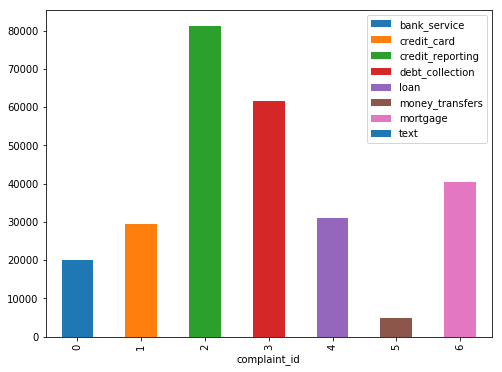

In [98]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))
plt.bar(10,bank_service_len,3, label="bank_service")
plt.bar(20,credit_card_len,3, label="credit_card")
plt.bar(30,credit_reporting_len,3, label="credit_reporting")
plt.bar(40,debt_collection_len,3, label="debt_collection")
plt.bar(50,loan_len,3, label="loan")
plt.bar(60,money_transfers_len,3, label="money_transfers")
plt.bar(70,mortgage_len,3, label="mortgage")
df.groupby('complaint_id').text.count().plot.bar(ylim=0)
plt.legend()
plt.show()

### 7.2. Data Preparation

As before, we first prepare the text for analysis by Vectorizing it,
although we do it here differently in order to use the text in our
various models more effectively.

In [99]:
filtered_text = ["".join(item) for item in X.astype(str)]

In [102]:
exclude = set(string.punctuation)
clean_text = ''.join(ch for ch in filtered_sentence if ch not in exclude)


In [104]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1234)count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
features = tfidf_transformer.fit_transform(X_train_counts)
labels = X_train

In [132]:
print(features)

  (0, 41431)	0.08285179115718981
  (0, 26720)	0.2764500309596693
  (0, 45135)	0.057745381495485304
  (0, 43488)	0.1775152745142489
  (0, 10133)	0.17412724597977397
  (0, 49234)	0.24605177444761792
  (0, 86703)	0.058852593316320256
  (0, 85981)	0.1892005811586917
  (0, 70719)	0.16414838350799613
  (0, 95212)	0.13243141159552738
  (0, 42020)	0.05661435057574735
  (0, 36055)	0.2912141526276478
  (0, 13048)	0.19455875761141267
  (0, 61839)	0.0551398046122844
  (0, 52958)	0.1526857233291632
  (0, 29497)	0.22370840252343893
  (0, 48713)	0.0669185538932523
  (0, 95503)	0.06199517654686664
  (0, 52847)	0.1038271771835712
  (0, 21763)	0.16776731209419463
  (0, 82148)	0.1396143504832041
  (0, 85898)	0.1110451705031512
  (0, 95997)	0.08922015211886304
  (0, 59737)	0.05709955972432531
  (0, 12693)	0.07646776290410011
  :	:
  (187865, 74678)	0.0987259239409822
  (187865, 90176)	0.07484416198225746
  (187865, 92362)	0.19641401792554275
  (187865, 91592)	0.056431870306139796
  (187865, 29836)	0.07196

### 7.3. Checking the Data

Here we choose to check our vectorized data using Chi-Square testing and
examining unigrams and bigrams for each SCRA Issue (class). This will
give us an idea of the most important words and pair of words in the
text as they pertain to classification of complaints. Note that ``Well
Fargo'' is a bigram for ``Excessive Interest'' Perhaps suprisingly,
``"Well Fargo'' appears in the transcripts of USAA SCRA calls, probably
due to the high interest rates they were demanding from service members.
As a result of these violations, we should take care to note these as we
discuss SCRA with our members, who may have formally sought loans from
Wells Fargo, for instance. The other unigrams and bigrams should be
apparent.


## 8. Model Development and Execution

Here we prepare to implement and run our four models.

### 8.1. Model Preparation

As before, we define training and test sets and prepare them for a BOW
analysis with our models.


In [135]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')
features = tfidf.fit_transform(df.text).toarray()
labels = df.product_group

MemoryError: 

In [134]:
from sklearn.feature_selection import chi2
import numpy as np
#vectorizer = TfidfVectorizer()
features = vectorizer.fit_transform(text_bow_train, y_train)#vectorizer.fit_transform(X_train)
N = 2
for product_group, category_id in sorted(category_to_id.items()):
  features_chi2 = chi2(features, labels == product_group)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(vectorizer.get_feature_names())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
  print("# '{}':".format(product_group))
  print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))
  print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-N:])))

AttributeError: lower not found

In [107]:
from sklearn.feature_selection import chi2
import numpy as np
#vectorizer = TfidfVectorizer()
#features = model.fit(text_bow_train, y_train)#vectorizer.fit_transform(X_train)
N = 2
for product_group, category_id in sorted(category_to_id.items()):
  features_chi2 = chi2(features, labels == product_group)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(vectorizer.get_feature_names())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
  print("# '{}':".format(product_group))
  print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))
  print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-N:])))

# 'bank_service':
  . Most correlated unigrams:
. effectually
. zwickers
  . Most correlated bigrams:
. 
# 'credit_card':
  . Most correlated unigrams:
. effectually
. zwickers
  . Most correlated bigrams:
. 
# 'credit_reporting':
  . Most correlated unigrams:
. effectually
. zwickers
  . Most correlated bigrams:
. 
# 'debt_collection':
  . Most correlated unigrams:
. effectually
. zwickers
  . Most correlated bigrams:
. 
# 'loan':
  . Most correlated unigrams:
. effectually
. zwickers
  . Most correlated bigrams:
. 
# 'money_transfers':
  . Most correlated unigrams:
. effectually
. zwickers
  . Most correlated bigrams:
. 
# 'mortgage':
  . Most correlated unigrams:
. effectually
. zwickers
  . Most correlated bigrams:
. 


In [124]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1234)#count_vect = CountVectorizer()
#X_train_counts = count_vect.fit_transform(X_train)
#tfidf_transformer = TfidfTransformer()
#X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
clf = MultinomialNB().fit(text_bow_train, y_train)

### 8.2. Model Execution

Now we setup and run the four models uing our BOWs.

In [136]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]

In [137]:
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])
import seaborn as sns
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

TypeError: Singleton array array(MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True),
      dtype=object) cannot be considered a valid collection.

In [ ]:
## 9. Model Analysis

Now we turn to our analysis of the models output and performance.

### 9.1. Anlysis of Model Performance

To start with, we can see on the graph above our models from lef to
right: the random forest classification model, the support vector
machine (SVM), the multinomial Bayes classification mode, and the
multinomial logistic regression model. From the graph it appears that
the SVM provides the best performance. This is supported by the model
accuracy metric shown below, with about 98%.

In [ ]:
cv_df.groupby('model_name').accuracy.mean()

In [ ]:
### 9.2. Confusion Matrix

Here, we cut to the chase and look at the confusion matrix provided by
the SVM. Although we show the confusion matrix, the normalized confusion
matrix is more informative (section 9.3).


In [ ]:
model = LinearSVC()
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df.index, test_size=0.33, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df.SCRA_ISSUE.values, yticklabels=category_id_df.SCRA_ISSUE.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [ ]:
=== 9.3. Normalized Confusion Matrix

Given the matrix below and 96.653% accuracy:

* ``Eviction'' is accurately 93.4% of the time, and incorrectly
classifies an SCRA issue as ``None'' 6.6% of the time.
* ``Excessive Interest'' is accurately 86.1% of the time, and
incorrectly classifies an SCRA issue as ``Eviction'' 0.4% of the time,
``Foreclosure'' 9.1% of the time, ``None'' 4.1% of the time, and
``Repossession'' 0.4% of the time.
* ``Foreclosure'' is accurately 84.9% of the time, and incorrectly
classifies an SCRA issue as ``Eviction'' 2.7% of the time, ``Excessive
Interest'' 8.9% of the time, and ``None'' 3.5% of the time.
* ``None'' is accurately 100.0% of the time.
* ``Repossession'' is accurately 50.0% of the time, and incorrectly
classifies an SCRA issue as ``Excessive Interest'' 31.5%" of the time,
and ``None'' 18.5% of the time.

Recall = 82.9%, Precision is 90.1%, and the F1 Score is 85.0%

In [ ]:
result = model.score(X_test, y_test)
print("Accuracy: %.3f%%" % (result*100.0))
y_pred = model.predict(X_test)
print("F1 Score: ", f1_score(y_test, y_pred, average="macro"))
print("Precision Score: ", precision_score(y_test, y_pred, average="macro"))
print("Recall Score: ", recall_score(y_test, y_pred, average="macro")) 
cm_analysis(y_test, y_pred, model.classes_, ymap=None, figsize=(10,10))

9.4. Anecdotal Evidence

For anecdotal evidence, we printed out five excerpt from the predicted
data. All are well within reason, provided the resullts shown by the
confussion matrix.

In [ ]:
from IPython.display import display
for predicted in category_id_df.category_id:
  for actual in category_id_df.category_id:
    if predicted != actual and conf_mat[actual, predicted] >= 10:
      print("'{}' predicted as '{}' : {} examples.".format(id_to_category[actual], id_to_category[predicted], conf_mat[actual, predicted]))
      display(df.loc[indices_test[(y_test == actual) & (y_pred == predicted)]][['SCRA_ISSUE', 'COMPLAINT']])
      print('')

In [ ]:
9.5. Unigrams and Bigrams

Notice the similaries and differences between with our earlier analysis.

In [ ]:
model.fit(features, labels)
N = 2
for Product, category_id in sorted(category_to_id.items()):
  indices = np.argsort(model.coef_[category_id])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 1][:N]
  bigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 2][:N]
  print("# '{}':".format(Product))
  print("  . Top unigrams:\n       . {}".format('\n       . '.join(unigrams)))
  print("  . Top bigrams:\n       . {}".format('\n       . '.join(bigrams)))

In [ ]:
9.6. Detailed Metrics

The following provides the details that we summarized in section 9.3.

In [ ]:
from sklearn import metrics
print(metrics.classification_report(y_test, y_pred, target_names=df['SCRA_ISSUE'].unique()))
